# D(St)reams of Anomalies

## Introduction

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 

#import warnings
#warnings.filterwarnings("ignore")

In [3]:
df=pd.read_csv("/Users/anissakhan/Dropbox/Nissa_stuff/KU_CS/EECS731/731-Project-6-Khan/Data/RawData/Twitter_volume_AAPL.csv")
df

,timestamp,value
0,2015-02-26 21:42:53,104
1,2015-02-26 21:47:53,100
2,2015-02-26 21:52:53,99
3,2015-02-26 21:57:53,154
4,2015-02-26 22:02:53,120
...,...,...
15897,2015-04-23 02:27:53,44
15898,2015-04-23 02:32:53,45
15899,2015-04-23 02:37:53,48
15900,2015-04-23 02:42:53,26


In [4]:
df.dtypes

timestamp    object
value         int64
dtype: object

In [5]:
df.describe()

,value
count,15902.000000
mean,85.552320
std,321.050721
min,0.000000
25%,29.000000
50%,47.000000
75%,76.000000
max,13479.000000


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15902 entries, 0 to 15901
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   timestamp  15902 non-null  object
 1   value      15902 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 248.6+ KB


In [7]:
dfTime=pd.read_csv('/Users/anissakhan/Dropbox/Nissa_stuff/KU_CS/EECS731/731-Project-6-Khan/Data/RawData/Twitter_volume_AAPL.csv', index_col ='timestamp', parse_dates = True)

In [8]:
dfTime

,value
timestamp,
2015-02-26 21:42:53,104
2015-02-26 21:47:53,100
2015-02-26 21:52:53,99
2015-02-26 21:57:53,154
2015-02-26 22:02:53,120
...,...
2015-04-23 02:27:53,44
2015-04-23 02:32:53,45
2015-04-23 02:37:53,48


Text(0, 0.5, '# of Mentions')

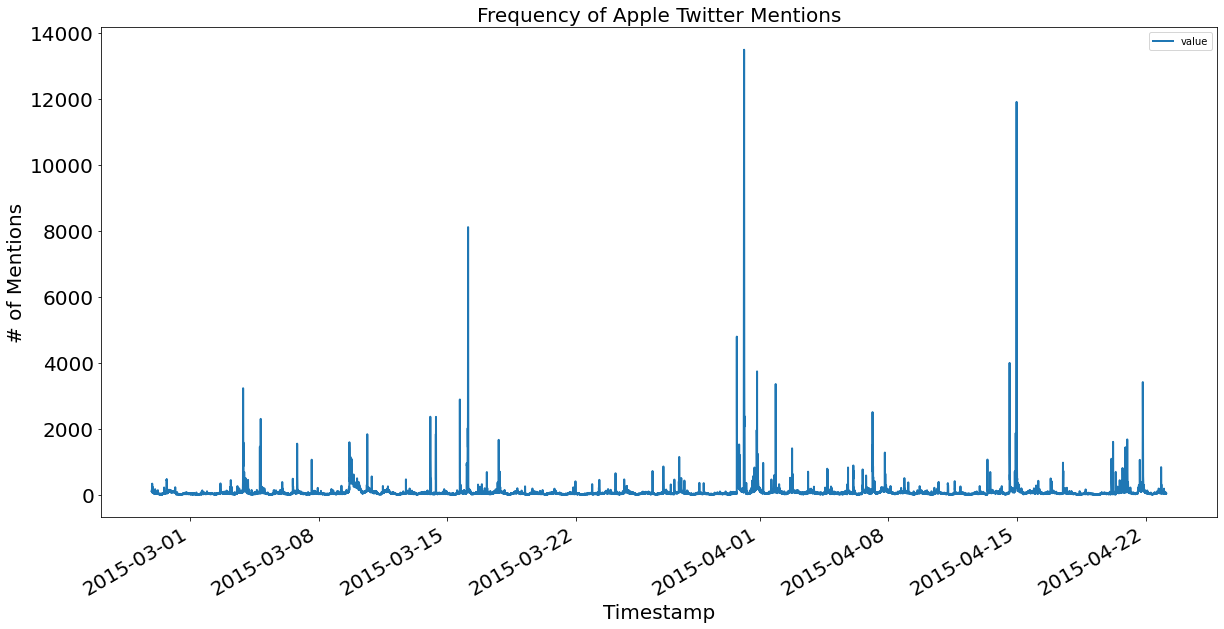

In [9]:
dfTime.plot(figsize=(20,10), linewidth=2, fontsize=20)
plt.xlabel('Timestamp', fontsize=20);
plt.title('Frequency of Apple Twitter Mentions', fontsize=20)
plt.ylabel('# of Mentions', fontsize=20)

Text(0, 0.5, 'Frequency')

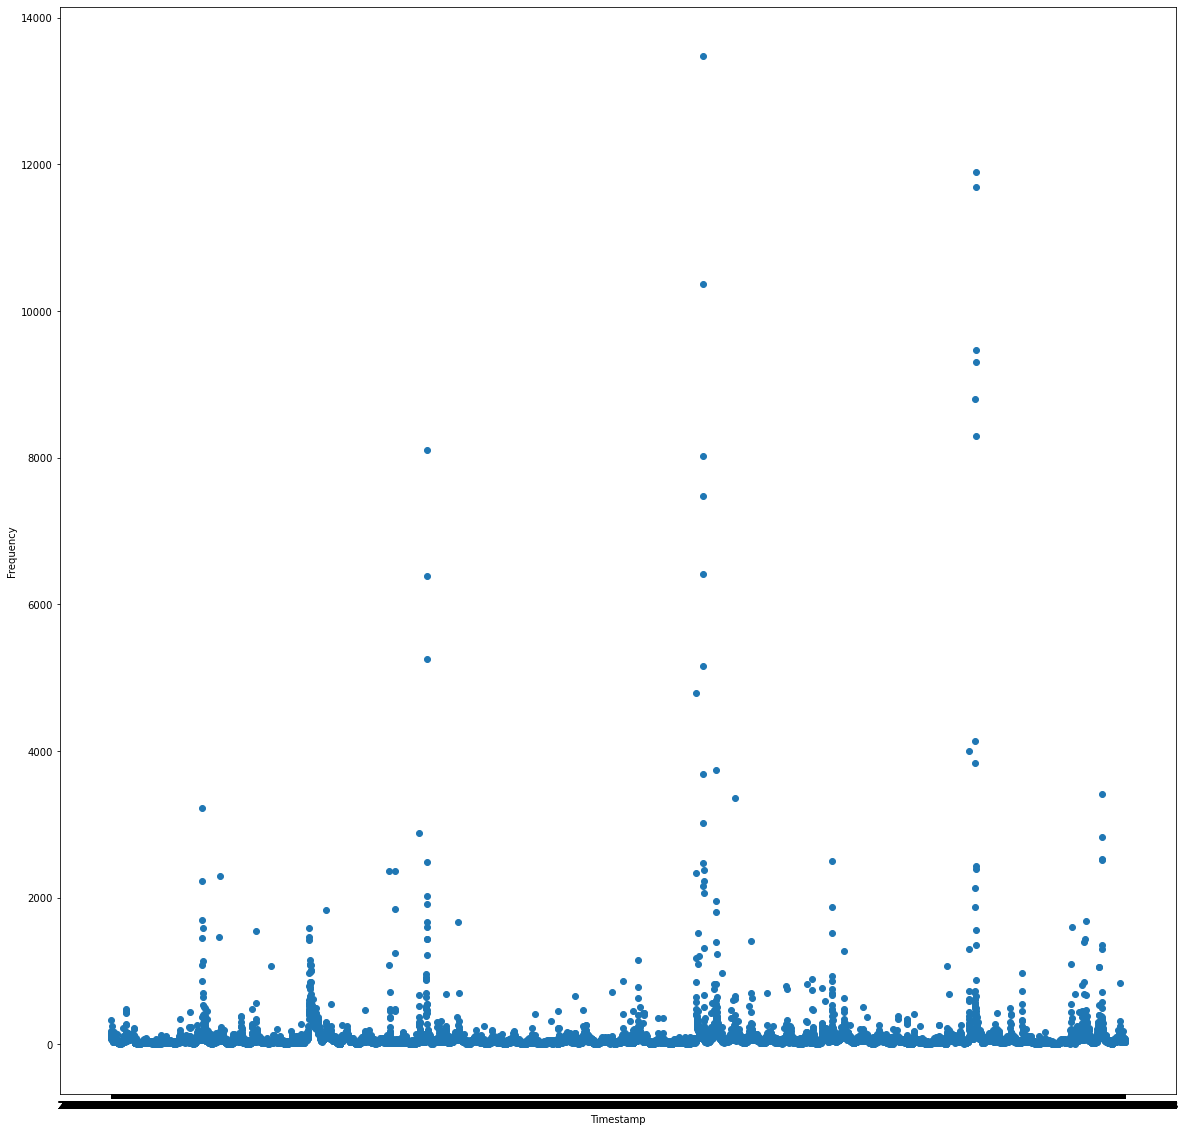

In [20]:
plt.figure(figsize=(20,20))
plt.scatter(df['timestamp'], df['value'])
plt.title('')
plt.xlabel('Timestamp')
plt.ylabel('Frequency')

In [ ]:
from sklearn.neighbors import LocalOutlierFactor

X=np.array(df['value']).reshape(-1,1)
#y=np.array(df['']).reshape(-1,1)
ground_truth = np.ones(len(X), dtype=int)

# fit the model for outlier detection (default)
clf = LocalOutlierFactor(n_neighbors=20, contamination=0.1)
# use fit_predict to compute the predicted labels of the training samples
# (when LOF is used for outlier detection, the estimator has no predict,
# decision_function and score_samples methods).
y_pred = clf.fit_predict(X)
n_errors = (y_pred != ground_truth).sum()
X_scores = clf.negative_outlier_factor_

plt.title("Local Outlier Factor (LOF)")
plt.scatter(X[:, 0], X[:, 1], color='k', s=3., label='Data points')
# plot circles with radius proportional to the outlier scores
radius = (X_scores.max() - X_scores) / (X_scores.max() - X_scores.min())
plt.scatter(X[:, 0], X[:, 1], s=1000 * radius, edgecolors='r',
            facecolors='none', label='Outlier scores')
plt.axis('tight')
plt.xlim((-5, 5))
plt.ylim((-5, 5))
plt.xlabel("prediction errors: %d" % (n_errors))
legend = plt.legend(loc='upper left')
legend.legendHandles[0]._sizes = [10]
legend.legendHandles[1]._sizes = [20]
plt.show()

In [10]:
from sklearn.ensemble import IsolationForest

In [33]:
from sklearn.model_selection import train_test_split # Import train_test_split function
X_train, X_test = train_test_split(df[['value']], test_size=0.3, random_state=1)

In [41]:
model=IsolationForest(n_estimators=50, max_samples='auto', contamination=float(0.1),max_features=1.0)
model.fit(df[['value']])
#model.fit(X_train)

IsolationForest(contamination=0.1, n_estimators=50)

In [42]:
df['scores']=model.decision_function(df[['value']])
df['anomaly']=model.predict(df[['value']])
df.head(20)

,timestamp,value,scores,anomaly
0,2015-02-26 21:42:53,104,0.040293,1
1,2015-02-26 21:47:53,100,0.042940,1
2,2015-02-26 21:52:53,99,0.041793,1
3,2015-02-26 21:57:53,154,-0.037967,-1
4,2015-02-26 22:02:53,120,0.028865,1
5,2015-02-26 22:07:53,90,0.069752,1
6,2015-02-26 22:12:53,92,0.067449,1
7,2015-02-26 22:17:53,71,0.090711,1
8,2015-02-26 22:22:53,339,-0.154482,-1
9,2015-02-26 22:27:53,178,-0.068194,-1


In [43]:
anomaly=df.loc[df['anomaly']==-1]
anomaly_index=list(anomaly.index)
print(anomaly)

                 timestamp  value    scores  anomaly
3      2015-02-26 21:57:53    154 -0.037967       -1
8      2015-02-26 22:22:53    339 -0.154482       -1
9      2015-02-26 22:27:53    178 -0.068194       -1
10     2015-02-26 22:32:53    144 -0.025558       -1
11     2015-02-26 22:37:53    143 -0.016927       -1
...                    ...    ...       ...      ...
15820  2015-04-22 20:02:53    257 -0.124899       -1
15821  2015-04-22 20:07:53    838 -0.269192       -1
15822  2015-04-22 20:12:53    177 -0.067429       -1
15824  2015-04-22 20:22:53    317 -0.146430       -1
15866  2015-04-22 23:52:53    187 -0.065811       -1

[1575 rows x 4 columns]


In [44]:
outliers_counter = len(df[df['value'] > 125])
outliers_counter

1607

In [45]:
print("Accuracy percentage:", 100*list(df['anomaly']).count(-1)/(outliers_counter))

Accuracy percentage: 98.00871188550093


In [161]:
df=pd.read_csv("/Users/anissakhan/Dropbox/Nissa_stuff/KU_CS/EECS731/731-Project-6-Khan/Data/RawData/Twitter_volume_AAPL.csv")
df.head()

,timestamp,value
0,2015-02-26 21:42:53,104
1,2015-02-26 21:47:53,100
2,2015-02-26 21:52:53,99
3,2015-02-26 21:57:53,154
4,2015-02-26 22:02:53,120


In [162]:
def datetime_to_float(d):
    return d.timestamp()

In [202]:
#n_estimators=100, max_samples='auto', contamination=float(.12), \
#                        max_features=1.0, bootstrap=False, n_jobs=-1, random_state=42, verbose=0

In [227]:
from sklearn.ensemble import IsolationForest
clf=IsolationForest(n_estimators=50, max_samples=2000, contamination='auto',max_features=1.0)
clf.fit(df[['value']])
pred = clf.predict(df[['value']])
df['anomaly']=pred
outliers=df.loc[df['anomaly']==-1]
outlier_index=list(outliers.index)
#print(outlier_index)
#Find the number of anomalies and normal points here points classified -1 are anomalous
print(df['anomaly'].value_counts())

 1    14967
-1      935
Name: anomaly, dtype: int64


In [228]:
for i in range(0,len(df['timestamp'])):
    df['timestamp'][i] = df['timestamp'][i].replace("-", "")
    df['timestamp'][i] = df['timestamp'][i].replace(":", "")
    df['timestamp'][i] = df['timestamp'][i].replace(" ", "")

<ipython-input-228-789c84a8aa6b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['timestamp'][i] = df['timestamp'][i].replace("-", "")
<ipython-input-228-789c84a8aa6b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['timestamp'][i] = df['timestamp'][i].replace(":", "")
<ipython-input-228-789c84a8aa6b>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['timestamp'][i] = df['timestamp'][i].replace(" ", "")


In [229]:
df.head()

,timestamp,value,anomaly
0,20150226214253,104,1
1,20150226214753,100,1
2,20150226215253,99,1
3,20150226215753,154,1
4,20150226220253,120,1


In [230]:
feature_cols = ['timestamp', 'value']
X = df[feature_cols]

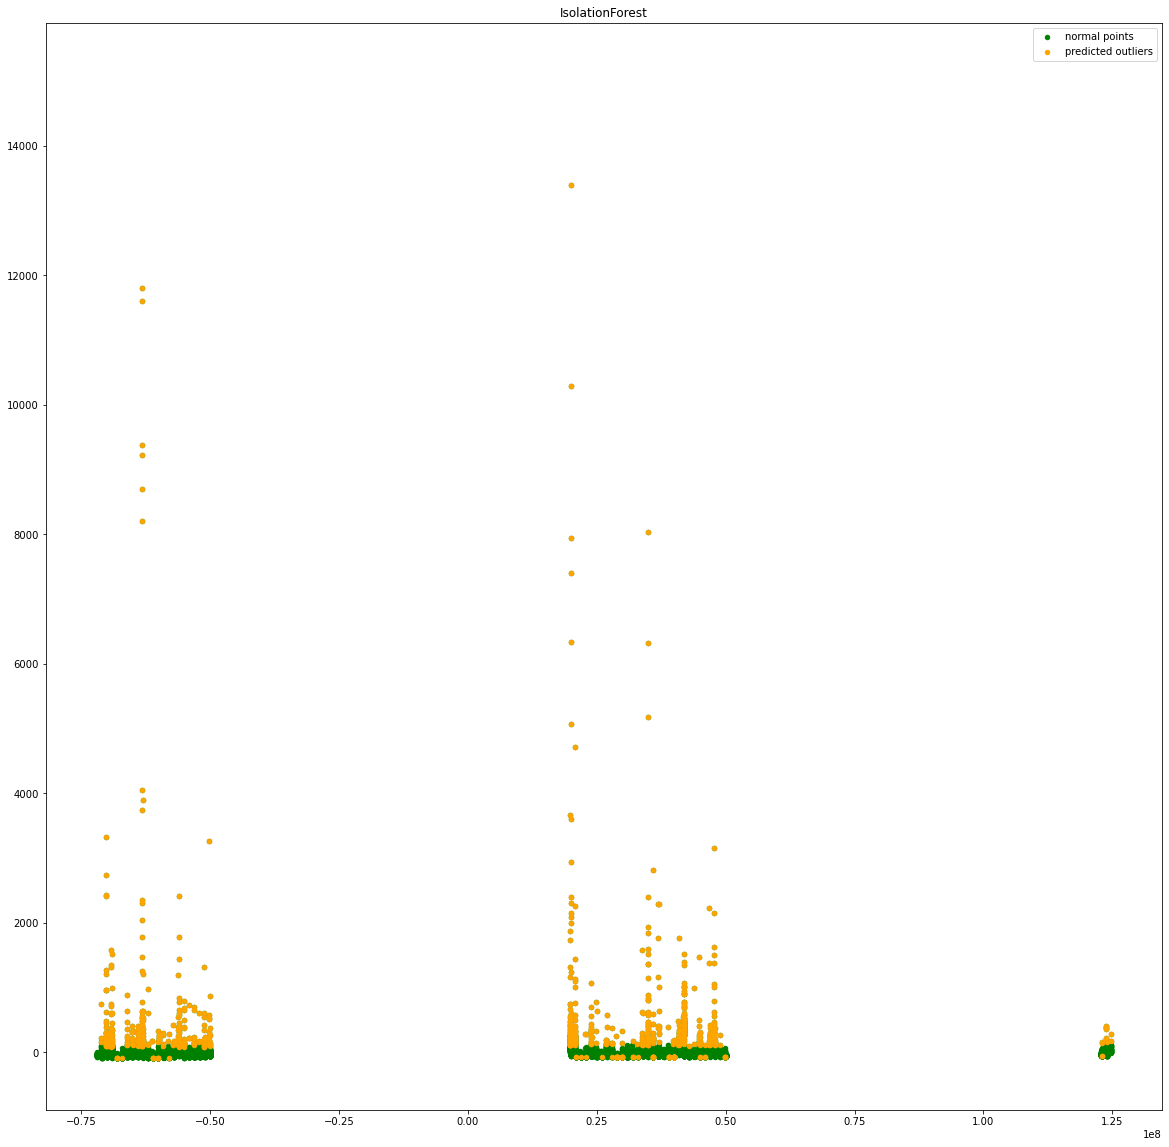

In [232]:
from sklearn.decomposition import PCA
pca = PCA(2)
pca.fit(X)
res=pd.DataFrame(pca.transform(X))
Z = np.array(res)
plt.figure(figsize=(20,20))
plt.title("IsolationForest")
plt.contourf( Z, cmap=plt.cm.Blues_r)
b1 = plt.scatter(res[0], res[1], c='green',
                 s=20,label="normal points")
b1 =plt.scatter(res.iloc[outlier_index,0],res.iloc[outlier_index,1], c='orange',s=20,  edgecolor="orange",label="predicted outliers")
plt.legend(loc="upper right")
plt.show()

In [234]:
import numpy as np 
from scipy import stats 
import matplotlib.pyplot as plt 
import matplotlib.font_manager 
from pyod.models.knn import KNN  
from pyod.utils.data import generate_data, get_outliers_inliers

In [ ]:
# Training the classifier 
clf = KNN(contamination = outlier_fraction) 
clf.fit(X_train, y_train) 
  
# You can print this to see all the prediciton scores 
scores_pred = clf.decision_function(X_train)*-1
  
y_pred = clf.predict(X_train) 
n_errors = (y_pred != y_train).sum() 
# Counting the number of errors 
  
print('The number of prediciton errors are ' + str(n_errors))